# Determine train and test images (+ masks). Create lists of them.

the code was taken from here:
https://keras.io/examples/vision/oxford_pets_image_segmentation/#perpare-unet-xceptionstyle-model

In [10]:
import os
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

input_dir = "L2/training_set/images"
target_dir = "L2/training_set/masks"
img_size = (224, 160)
num_classes = 3
batch_size = 32

#tot_num_images = len([name for name in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, name))])

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
tot_num_images =  len(input_img_paths)
print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 541
L2/training_set/images\000008372_Ycrop_Hres_L.png | L2/training_set/masks\000008372_Ycrop_Hres_L.png
L2/training_set/images\000008373_Ycrop_Hres_R.png | L2/training_set/masks\000008373_Ycrop_Hres_R.png
L2/training_set/images\000008374_Ycrop_Hres_L.png | L2/training_set/masks\000008374_Ycrop_Hres_L.png
L2/training_set/images\000008375_Ycrop_Hres_L.png | L2/training_set/masks\000008375_Ycrop_Hres_L.png
L2/training_set/images\000008377_Ycrop_Hres_L.png | L2/training_set/masks\000008377_Ycrop_Hres_L.png
L2/training_set/images\000008378_Ycrop_Hres_R.png | L2/training_set/masks\000008378_Ycrop_Hres_R.png
L2/training_set/images\000008379_Ycrop_Hres_R.png | L2/training_set/masks\000008379_Ycrop_Hres_R.png
L2/training_set/images\000008382_Ycrop_Hres_R.png | L2/training_set/masks\000008382_Ycrop_Hres_R.png
L2/training_set/images\000008383_Ycrop_Hres_R.png | L2/training_set/masks\000008383_Ycrop_Hres_R.png
L2/training_set/images\000008384_Ycrop_Hres_R.png | L2/training_set/

## Define the EyePupil class
# this class will consist batched images and masks

In [3]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class EyePupil(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y

## Define the model. U_Net.

In [4]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 80, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 80, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 80, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
import random

# Split our img paths into a training and a validation set
val_samples = int(tot_num_images * 0.3)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = EyePupil(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = EyePupil(batch_size, img_size, val_input_img_paths, val_target_img_paths)


## Train locally the model.
* the learning rate is small (local training)!
* The weights are initialized from the pre-trained model on Oxford dataset (Dog/Cats).

In [6]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
callbacks = [
    keras.callbacks.ModelCheckpoint("eyepupil_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
#model1=keras.models.load_model ('oxford_segmentation.h5')
#model1.save_weights('oxford_segmentation.weights')
model.load_weights('oxford_segmentation.weights')
opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy")


model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
11/11 [==============================] - 123s 10s/step - loss: 1.4382 - val_loss: 1.1349
Epoch 2/50
11/11 [==============================] - 107s 10s/step - loss: 0.0955 - val_loss: 0.7754
Epoch 3/50
11/11 [==============================] - 106s 10s/step - loss: 0.0748 - val_loss: 0.4893
Epoch 4/50
11/11 [==============================] - 107s 10s/step - loss: 0.0669 - val_loss: 0.4136
Epoch 5/50
11/11 [==============================] - 107s 10s/step - loss: 0.0685 - val_loss: 0.2880
Epoch 6/50
11/11 [==============================] - 105s 10s/step - loss: 0.0480 - val_loss: 0.1229
Epoch 7/50
11/11 [==============================] - 99s 9s/step - loss: 0.0527 - val_loss: 0.2090
Epoch 8/50
11/11 [==============================] - 100s 9s/step - loss: 0.0605 - val_loss: 0.1141
Epoch 9/50
11/11 [==============================] - 99s 9s/step - loss: 0.0352 - val_loss: 0.0887
Epoch 10/50
11/11 [==============================] - 98s 9s/step - loss: 0.0452 - val_loss: 0.1242
Epoch 

## Examine one example.
i=10 means the 11'th example in the validation dataset

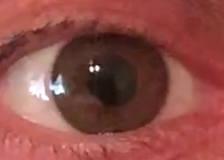

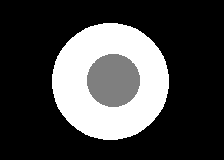

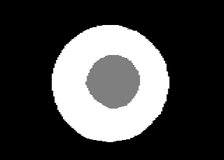

In [11]:
# Generate predictions for all images in the validation set
val_gen = EyePupil(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize(img_size)
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

## Display a list of results for the validation dataset.

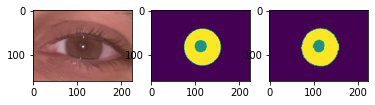

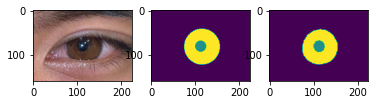

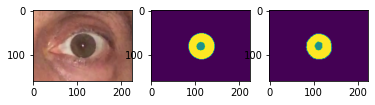

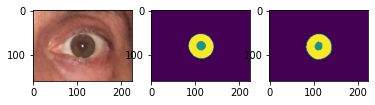

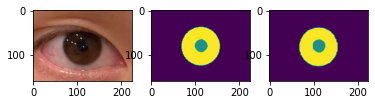

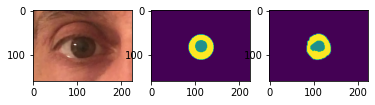

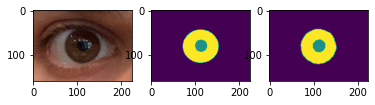

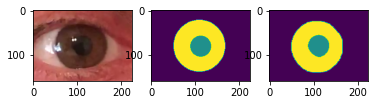

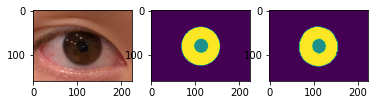

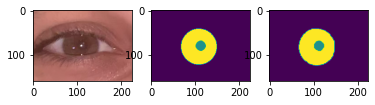

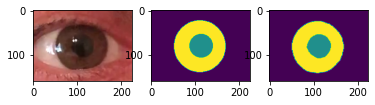

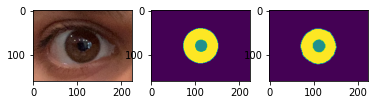

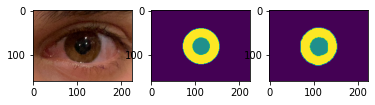

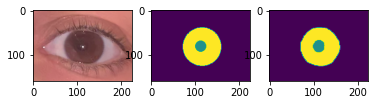

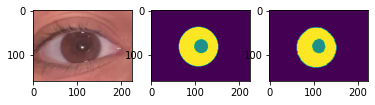

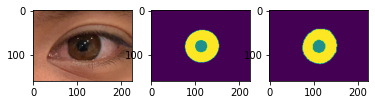

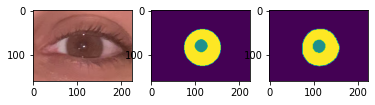

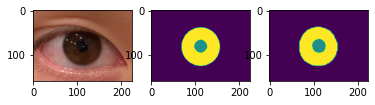

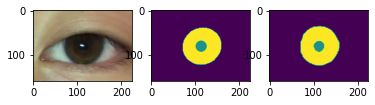

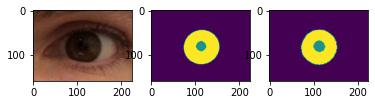

In [12]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

for i in range(20):
    f,ax = plt.subplots(1,3)
    img1=imread(val_input_img_paths[i])
    ax[0].imshow(img1)
    img2 = imread(val_target_img_paths[i]) 
    ax[1].imshow(img2)
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize(img_size)
    ax[2].imshow(img)

plt.show() # or display.display(plt.gcf()) if you prefer